## Подключение библиотеки

In [1]:
import timeit
import sys
import os
import re
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from scipy import stats as st
# Тренды и сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
# Проверка на стационарность
from statsmodels.tsa.stattools import adfuller, kpss
# Проверка на дисперсию с помощью теста Андерсона-Дарлинга
from scipy.stats import anderson

# Разбиение на обучающую, валидационную и тестовую выборку
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, TimeSeriesSplit

# Масштабируемость модели
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# Многозадачная регрессия
from sklearn.multioutput import MultiOutputRegressor
# Для машинного обучения
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
# Метод ближайшего соседа KNN
from sklearn.neighbors import KNeighborsRegressor
# Метод опорного вектора, SVR - для регрессии
from sklearn.svm import SVR

# Метрики
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

## Импорт и анализ данных

In [2]:
df = pd.read_csv('Amp_C_train.txt')

##### Рассмотрим содержимое датасет

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172032 entries, 0 to 172031
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    172032 non-null  float64
 1   Input   172032 non-null  object 
 2   Output  172032 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.9+ MB


In [4]:
# Приведение к нижнему регистру названия колонки
df.columns = df.columns.str.lower()

In [5]:
df.head()

,time,input,output
0,0.000000e+00,0j,(1.0785e-42-9.30535e-43j)
1,5.000000e-09,0j,(4.00167e-44+4.80805e-45j)
2,1.000000e-08,0j,(5.73102e-46+1.23143e-45j)
3,1.500000e-08,0j,(-2.47356e-47+3.89672e-47j)
4,2.000000e-08,0j,(-1.56497e-48+2.91821e-51j)


## Предобработка данных

### Сделаем датасет в временной ряд

In [6]:
# Установка колонки 'time' в качестве индекса
df.set_index('time', inplace=True)

### Преобразование комплексных входных и выходных сигналов из строкового представления

In [7]:
df['input'] = df['input'].apply(lambda x: complex(x.strip('()').replace('i', 'j')))
df['output'] = df['output'].apply(lambda x: complex(x.strip('()').replace('i', 'j')))

### Изменим DataFrame с реальной и мнимой частями комплексных чисел

In [8]:
df['input_real'] = df['input'].apply(np.real)
df['input_imag'] = df['input'].apply(np.imag)
df['output_real'] = df['output'].apply(np.real)
df['output_imag'] = df['output'].apply(np.imag)

In [9]:
df.head()

,input,output,input_real,input_imag,output_real,output_imag
time,,,,,,
0.000000e+00,0.0+0.0j,1.078500e-42-9.305350e- 43j,0.0,0.0,1.078500e-42,-9.305350e-43
5.000000e-09,0.0+0.0j,4.001670e-44+4.808050e- 45j,0.0,0.0,4.001670e-44,4.808050e-45
1.000000e-08,0.0+0.0j,5.731020e-46+1.231430e- 45j,0.0,0.0,5.731020e-46,1.231430e-45
1.500000e-08,0.0+0.0j,-2.473560e-47+3.896720e- 47j,0.0,0.0,-2.473560e-47,3.896720e-47
2.000000e-08,0.0+0.0j,-1.564970e-48+2.918210e- 51j,0.0,0.0,-1.564970e-48,2.918210e-51


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 172032 entries, 0.0 to 0.000860155
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype     
---  ------       --------------   -----     
 0   input        172032 non-null  complex128
 1   output       172032 non-null  complex128
 2   input_real   172032 non-null  float64   
 3   input_imag   172032 non-null  float64   
 4   output_real  172032 non-null  float64   
 5   output_imag  172032 non-null  float64   
dtypes: complex128(2), float64(4)
memory usage: 11.8 MB


In [11]:
df = df.drop(['input', 'output'], axis=1)

In [12]:
df.describe()

,input_real,input_imag,output_real,output_imag
count,172032.000000,172032.000000,172032.000000,172032.000000
mean,0.000053,-0.000013,-0.001947,-0.000626
std,0.592007,0.593872,2.087976,2.087590
min,-2.229120,-2.202991,-3.449150,-3.441910
25%,-0.399091,-0.399775,-1.934853,-1.937512
50%,-0.000685,-0.000342,-0.010191,0.004920
75%,0.398777,0.401744,1.935345,1.929125
max,2.212461,2.192265,3.451210,3.460060


## График

In [13]:
def draw_plot_signal(signal_type, time_start=0, time_end=1e-6):
    # Фильтрация данных по временной отметке
    filtered_data = df[(df.index >= time_start) & (df.index <= time_end)]
    time = filtered_data.index

    # Построение объединенного графика
    plt.figure(figsize=(10, 6))
    
    # Входной сигнал
    plt.plot(time, filtered_data[f'{signal_type}_real'], label=f'{signal_type} Real Part', color='blue', linestyle='-')
    plt.plot(time, filtered_data[f'{signal_type}_imag'], label=f'{signal_type} Imaginary Part', color='red', linestyle='-')
    
    plt.title('Input and Output Signals')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True)
    plt.show()

In [14]:
def draw_all_plot_signal(time_start=0, time_end=1e-6):
    # Фильтрация данных по временной отметке
    filtered_data = df[(df.index >= time_start) & (df.index <= time_end)]
    time = filtered_data.index
    
    plt.figure(figsize=(15, 10))

    # График реальной части входного сигнала
    plt.subplot(2, 2, 1)
    plt.plot(time, filtered_data['input_real'], label='Real Part')
    plt.title('Real Part of input Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # График мнимой части входного сигнала
    plt.subplot(2, 2, 2)
    plt.plot(time, filtered_data['input_imag'], label='Imaginary Part', color='orange')
    plt.title('Imaginary Part of input Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # График реальной части выходного сигнала
    plt.subplot(2, 2, 3)
    plt.plot(time, filtered_data['output_real'], label='Real Part')
    plt.title('Real Part of output Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    # График мнимой части выходного сигнала
    plt.subplot(2, 2, 4)
    plt.plot(time, filtered_data['output_imag'], label='Imaginary Part', color='orange')
    plt.title('Imaginary Part of output Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

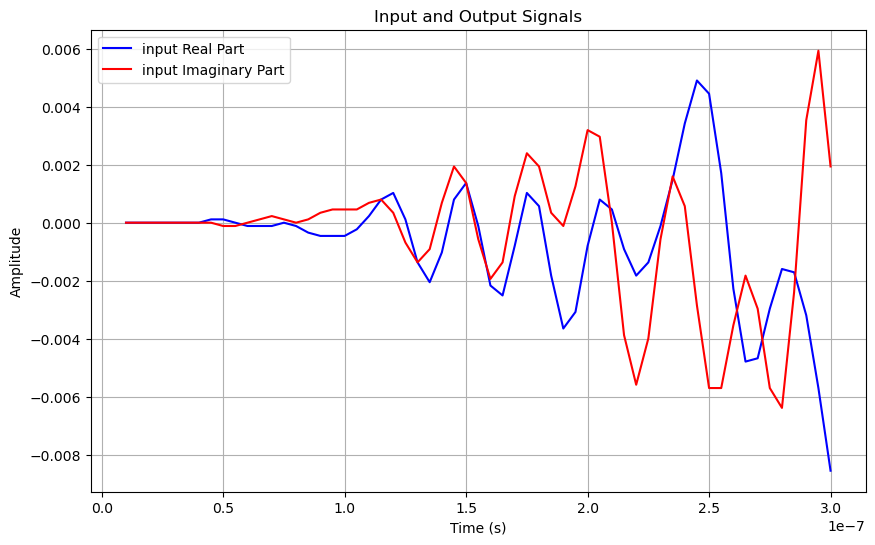

In [15]:
draw_plot_signal('input', time_start=1e-8, time_end=0.3e-6)

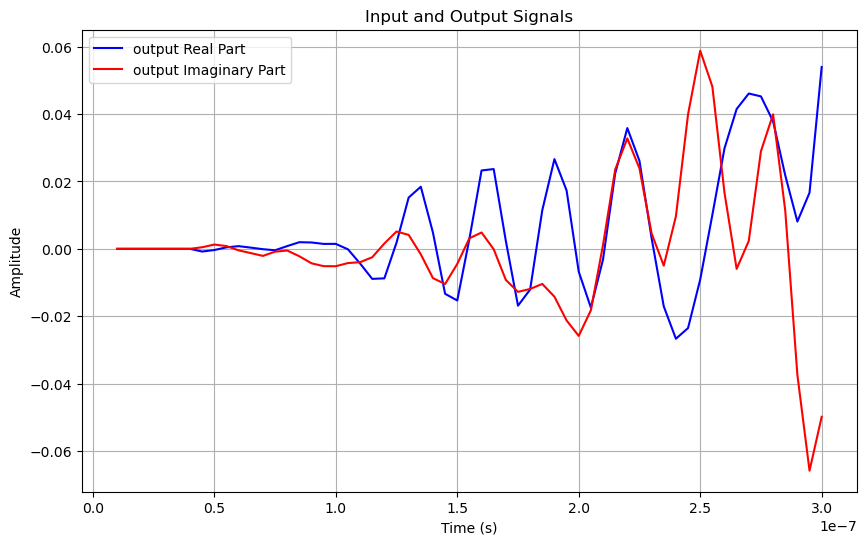

In [16]:
draw_plot_signal('output', time_start=1e-8, time_end=0.3e-6)

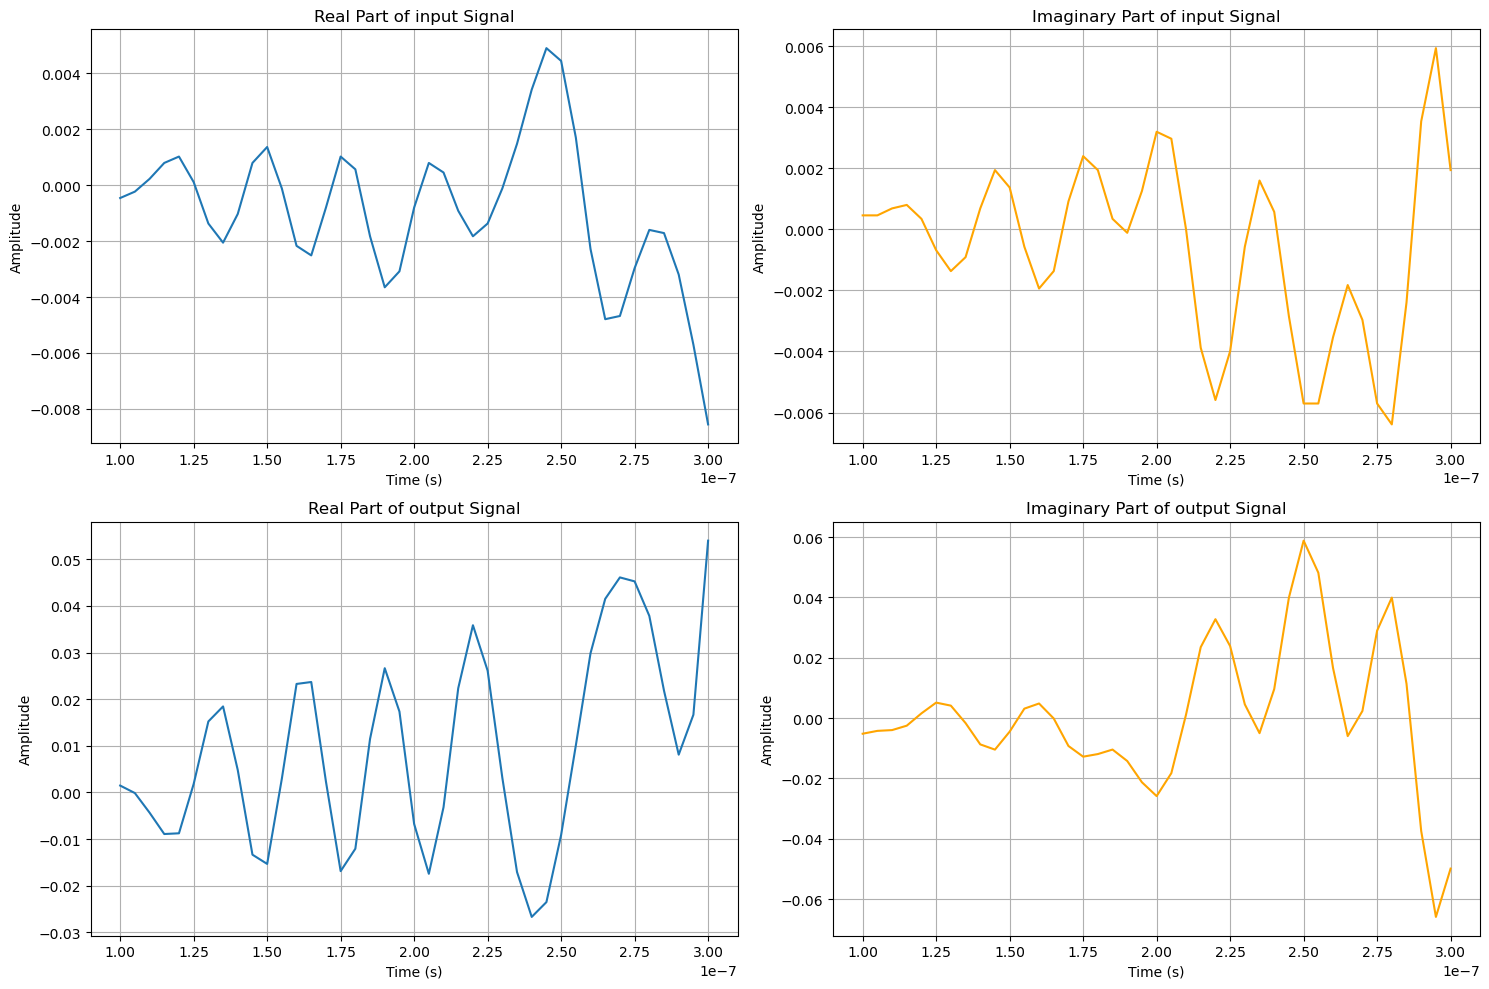

In [17]:
draw_all_plot_signal(time_start=1e-7, time_end=0.3e-6)

# Машинное обучение

In [18]:
# Здесь будем сохранить результаты машинного обучения
results = pd.DataFrame()

# А это будет счетчтиком для нумерация моеделй
count_model = 0

In [19]:
# Определение входных и выходных данных
features = df[['input_real', 'input_imag']]
targets = df[['output_real', 'output_imag']]

## Деление на обучающей и валидационной выборки

**Обучение моделей с применением TimeSeriesSplit**

Почему обучаем с применением TimeSeriesSplit, потому что мы обучаем модель, у которой по индексу стоит временный ряд. А чтобы они не пересекались, это поможет инструмент TimeSeriesSplit. Как работает, рассмотрим ниже

In [20]:
# Не будем создавать по-умолчанию, где n_splits=5, а установим n_splits=10
tscv = TimeSeriesSplit(10)
display(tscv)

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)

In [21]:
# Разделение на обучающую и валидационную выборки
features_train, features_valid, targets_train, targets_valid = train_test_split(features, targets, test_size=0.2, random_state=123456)

## Обучение модели

### LinearRegression

In [22]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель (включая масштабирование) и GridSearchCV
pipeline_scale = make_pipeline(StandardScaler(), LinearRegression())
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={}, scoring='neg_root_mean_squared_error')

In [23]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.8658672581599522
TIME TRAIN [s]: 0.02


**Проверка на валидационной выборки**

In [24]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.7488804442530592
RMSE для мнимой части: 0.7531629903468988
CPU times: user 25.3 ms, sys: 3.31 ms, total: 28.6 ms
Wall time: 3.47 ms


In [25]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                    LinearRegression
RMSE TRAIN                                                      0.865867
RMSE VALID REAL                                                  0.74888
RMSE VALID IMAG                                                 0.753163
TIME TRAINING [s]                                               0.020392
TIME PREDICTION [s]                                                0.002
PREDICTIONS            [[-0.28832698573917814, 1.936889405288186], [-...
PARAMETRS                                                             {}
Name: 0, dtype: object

### KNeighborsRegressor

In [26]:
# Задаем значения гиперпараметров
parameters = {
    # Пример значений, можно добавить свои
    'kneighborsregressor__n_neighbors': [1, 2],  
    # 'weights': ['uniform', 'distance'],
    'kneighborsregressor__weights': ['uniform'],
    # для параметра метрики (1 - манхэттенское расстояние, 2 - евклидово расстояние)
    # 'kneighborsregressor__p': [1]  
}

# Инициализируем модель (включая масштабирование) и GridSearchCV
pipeline_scale = make_pipeline(StandardScaler(), KNeighborsRegressor())
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             param_grid={'kneighborsregressor__n_neighbors': [1, 2],
                         'kneighborsregressor__weights': ['uniform']},
             scoring='neg_root_mean_squared_error')

In [27]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.3862943803573481
TIME TRAIN [s]: 0.06


**Проверка на валидационной выборки**

In [28]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.14756557815883273
RMSE для мнимой части: 0.1483683860179619
CPU times: user 74.4 ms, sys: 926 µs, total: 75.3 ms
Wall time: 73.7 ms


In [29]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                 KNeighborsRegressor
RMSE TRAIN                                                      0.386294
RMSE VALID REAL                                                 0.147566
RMSE VALID IMAG                                                 0.148368
TIME TRAINING [s]                                               0.060218
TIME PREDICTION [s]                                                0.073
PREDICTIONS            [[-0.44020349999999997, 2.974165], [-2.74305, ...
PARAMETRS              {'kneighborsregressor__n_neighbors': 2, 'kneig...
Name: 1, dtype: object

### DecisionTreeRegressor

In [30]:
parameters = {
    'decisiontreeregressor__max_depth': range(1, 101, 10),
    'decisiontreeregressor__min_samples_leaf': [1, 0.5]
}

# Инициализируем модель (включая масштабирование) и GridSearchCV
pipeline_scale = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=12345))
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor(random_state=12345))]),
             param_grid={'decisiontreeregressor__max_depth': range(1, 101, 10),
                         'decisiontreeregressor__min_samples_leaf': [1, 0.5]},
             scoring='neg_root_mean_squared_error')

In [31]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.37621486671960813
TIME TRAIN [s]: 0.3


**Проверка на валидационной выборки**

In [32]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.13459805580403986
RMSE для мнимой части: 0.1339878847137597
CPU times: user 4.89 ms, sys: 3 ms, total: 7.89 ms
Wall time: 6.19 ms


In [33]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                               DecisionTreeRegressor
RMSE TRAIN                                                      0.376215
RMSE VALID REAL                                                 0.134598
RMSE VALID IMAG                                                 0.133988
TIME TRAINING [s]                                               0.299427
TIME PREDICTION [s]                                                0.005
PREDICTIONS            [[-0.5637410662983423, 2.8974165193370167], [-...
PARAMETRS              {'decisiontreeregressor__max_depth': 11, 'deci...
Name: 2, dtype: object

### LightGBMRegressor

In [42]:
# Матрица гиперпараметров для LGBMRegressor
parameters = {
    'multioutputregressor__estimator__n_estimators': [10, 25],
    'multioutputregressor__estimator__learning_rate': [0.1, 0.3],
    'multioutputregressor__estimator__max_depth': [5, 15],
    'multioutputregressor__estimator__num_leaves': [5, 10],
}

# Оборачиваем LGBMR в MultiOutputRegressor
multi_target_lgbmr = MultiOutputRegressor(LGBMRegressor())

# Инициализируем модель с параметрами и создаем конвейер
pipeline_scale = make_pipeline(StandardScaler(), multi_target_lgbmr)
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('multioutputregressor',
                                        MultiOutputRegressor(estimator=LGBMRegressor()))]),
             param_grid={'multioutputregressor__estimator__learning_rate': [0.1,
                                                                            0.3],
                         'multioutputregressor__estimator__max_depth': [5, 15],
                         'multioutputregressor__estimator__n_estimators': [10,
                                                                           25],
                         'multioutputregressor__estimator__num_leaves': [5,
                                                                         10]},
             scoring='neg_root_mean_squared_error')

In [43]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 12515, number of used features: 2
[LightGBM] [Info] Start training from score 0.003815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 12515, number of used features: 2
[LightGBM] [Info] Start training from score 0.015188
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 250

**Проверка на валидационной выборки**

In [44]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.1713299102926755
RMSE для мнимой части: 0.1723867719656781
CPU times: user 103 ms, sys: 3.77 ms, total: 106 ms
Wall time: 18.4 ms


In [ ]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

### CatBoostRegressor

In [49]:
# Матрица гиперпараметров для CatBoostRegressor
parameters = {
    'multioutputregressor__estimator__iterations': [5, 10],
    'multioutputregressor__estimator__learning_rate': [0.1, 0.5],
    'multioutputregressor__estimator__depth': [5, 15],
}

# Оборачиваем CatBoostRegressor в MultiOutputRegressor
multi_target_cbr = MultiOutputRegressor(CatBoostRegressor())

# Инициализируем модель с параметрами и создаем конвейер
pipeline_scale = make_pipeline(StandardScaler(), multi_target_cbr)
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('multioutputregressor',
                                        MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x7babe05bdb90>))]),
             param_grid={'multioutputregressor__estimator__depth': [5, 15],
                         'multioutputregressor__estimator__iterations': [5, 10],
                         'multioutputregressor__estimator__learning_rate': [0.1,
                                                                            0.5]},
             scoring='neg_root_mean_squared_error')

In [50]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

0:	learn: 1.9013737	total: 50.9ms	remaining: 204ms
1:	learn: 1.7306095	total: 52.6ms	remaining: 78.9ms
2:	learn: 1.5795488	total: 54.4ms	remaining: 36.3ms
3:	learn: 1.4394106	total: 55.7ms	remaining: 13.9ms
4:	learn: 1.3128407	total: 57.2ms	remaining: 0us
0:	learn: 1.9010003	total: 1.26ms	remaining: 5.03ms
1:	learn: 1.7313272	total: 2.39ms	remaining: 3.59ms
2:	learn: 1.5814113	total: 3.8ms	remaining: 2.53ms
3:	learn: 1.4447014	total: 4.95ms	remaining: 1.24ms
4:	learn: 1.3188330	total: 6.2ms	remaining: 0us
0:	learn: 1.9039942	total: 2.22ms	remaining: 8.88ms
1:	learn: 1.7343293	total: 4.39ms	remaining: 6.58ms
2:	learn: 1.5823872	total: 5.88ms	remaining: 3.92ms
3:	learn: 1.4419239	total: 7.33ms	remaining: 1.83ms
4:	learn: 1.3152449	total: 8.98ms	remaining: 0us
0:	learn: 1.9005997	total: 1.62ms	remaining: 6.48ms
1:	learn: 1.7316318	total: 3.47ms	remaining: 5.2ms
2:	learn: 1.5763051	total: 5.39ms	remaining: 3.6ms
3:	learn: 1.4377097	total: 7.18ms	remaining: 1.79ms
4:	learn: 1.3136369	total:

**Проверка на валидационной выборки**

In [51]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.14433298570142392
RMSE для мнимой части: 0.1442852424131891
CPU times: user 16.8 ms, sys: 12.3 ms, total: 29.1 ms
Wall time: 9.4 ms


In [52]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                MultiOutputRegressor
RMSE TRAIN                                                       0.38449
RMSE VALID REAL                                                 0.144333
RMSE VALID IMAG                                                 0.144285
TIME TRAINING [s]                                                5.30733
TIME PREDICTION [s]                                                0.009
PREDICTIONS            [[-0.5793409857007769, 3.00895793161571], [-2....
PARAMETRS              {'multioutputregressor__estimator__depth': 15,...
Name: 3, dtype: object

### BaggingRegressor

In [53]:
# Матрица гиперпараметров для BaggingRegressor
parameters = {
    'baggingregressor__n_estimators': [10, 25],
    'baggingregressor__random_state': [12345] 
}

# Инициализируем модель с параметрами и создаем конвейер
# Инициализируем BaggingRegressor отдельно
bagging_model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10), random_state=12345)
pipeline_scale = make_pipeline(StandardScaler(), bagging_model)
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('baggingregressor',
                                        BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10),
                                                         random_state=12345))]),
             param_grid={'baggingregressor__n_estimators': [10, 25],
                         'baggingregressor__random_state': [12345]},
             scoring='neg_root_mean_squared_error')

In [54]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

RMSE TRAIN: 0.35696216171103107
TIME TRAIN [s]: 4.4


**Проверка на валидационной выборки**

In [55]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

RMSE для действительной части: 0.12555557093909708
RMSE для мнимой части: 0.1261163382483048
CPU times: user 103 ms, sys: 0 ns, total: 103 ms
Wall time: 102 ms


In [56]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

NAME                                                    BaggingRegressor
RMSE TRAIN                                                      0.356962
RMSE VALID REAL                                                 0.125556
RMSE VALID IMAG                                                 0.126116
TIME TRAINING [s]                                                4.40312
TIME PREDICTION [s]                                                0.101
PREDICTIONS            [[-0.5211061075152857, 3.000718101419898], [-2...
PARAMETRS              {'baggingregressor__n_estimators': 25, 'baggin...
Name: 4, dtype: object

### StackingRegressor

In [61]:
# Матрица гиперпараметров для StackingRegressor
parameters = {
    # Параметр регуляризации для финальной модели (линейной)
    'multioutputregressor__estimator__final_estimator__C': [0.5],  
    # Тип ядра для финальной модели (линейное)
    'multioutputregressor__estimator__final_estimator__kernel': ['linear'],  
    # Количество фолдов во внутренней кросс-валидации StackingRegressor
    'multioutputregressor__estimator__cv': [2],  
}

# Инициализируем базовые модели
base_models = [('dt', DecisionTreeRegressor()), ('knn', KNeighborsRegressor())]

# Инициализируем StackingRegressor с базовыми моделями
stacking_model = StackingRegressor(estimators=base_models, final_estimator=SVR())

# Оборачиваем StackingRegressor в MultiOutputRegressor для поддержки многомерных целевых переменных
multi_target_stacking = MultiOutputRegressor(stacking_model)

# Создаем конвейер
pipeline_scale = make_pipeline(StandardScaler(), multi_target_stacking)
model = GridSearchCV(pipeline_scale, param_grid=parameters, cv=tscv, scoring='neg_root_mean_squared_error')
display(model)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('multioutputregressor',
                                        MultiOutputRegressor(estimator=StackingRegressor(estimators=[('dt',
                                                                                                      DecisionTreeRegressor()),
                                                                                                     ('knn',
                                                                                                      KNeighborsRegressor())],
                                                                                         final_estimator=SVR())))]),
             param_grid={'multioutputregressor__estimator__cv': [2],
                         'multioutputregressor__estimator__final_estimator__C': [0.5],
                         'multioutputregressor__estimator__final_estimator__kernel': ['linear']},
             scoring='neg_root_mean_squared_error')

In [ ]:
# Обучим модель на обучающей выборке
model.fit(features_train, targets_train)
time = model.refit_time_
params = model.best_params_

# Узнаем RMSE обучающей выборки
rmse_train = np.sqrt(-model.best_score_)
print('RMSE TRAIN:', rmse_train)
print('TIME TRAIN [s]:', round(time, 2))

**Проверка на валидационной выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на валидационной выборки
predictions = model.predict(features_valid)

elapsed = round(timeit.default_timer() - start_time, 3)

# Узнаем RMSE output_real и output_imag
rmse_valid_real = np.sqrt(mean_squared_error(targets_valid['output_real'], predictions[:, 0]))
rmse_valid_imag = np.sqrt(mean_squared_error(targets_valid['output_imag'], predictions[:, 1]))

print(f'RMSE для действительной части: {rmse_valid_real}')
print(f'RMSE для мнимой части: {rmse_valid_imag}')

In [ ]:
# Зафиксируем результаты
results[count_model] = pd.Series({
    'NAME': pipeline_scale.named_steps[pipeline_scale.steps[-1][0]].__class__.__name__, 
    'RMSE TRAIN': rmse_train, 
    'RMSE VALID REAL': rmse_valid_real, 
    'RMSE VALID IMAG': rmse_valid_imag, 
    'TIME TRAINING [s]': model.refit_time_, 
    'TIME PREDICTION [s]': elapsed, 
    'PREDICTIONS': predictions, 
    'PARAMETRS': model.best_params_
})

display(results[count_model])
count_model+=1

# Результаты

In [ ]:
results = pd.DataFrame(results).T

In [ ]:
# Смотрим на результаты
results

In [ ]:
# Рассчитываем рейтинг с учетом указанных приоритетов
results['RATING'] = (
    0.4 * (1 - (results['RMSE VALID REAL'] / results['RMSE VALID REAL'].max())) +
    0.4 * (1 - (results['RMSE VALID IMAG'] / results['RMSE VALID IMAG'].max())) +
    0.1 * (1 - (results['TIME TRAINING [s]'] / results['TIME TRAINING [s]'].max())) +
    0.1 * (1 - (results['TIME PREDICTION [s]'] / results['TIME PREDICTION [s]'].max()))
)

# Сортируем DataFrame по убыванию рейтинга
results = results.sort_values(by='RATING', ascending=False)

In [ ]:
# Смотрим на результаты
results

**Создадим отдельный датасет, в котором будет храниться реальное значение и предсказания модели**

In [ ]:
# Используем индексы валидационных данных
info_result = pd.DataFrame(index=targets_valid.index)

info_result['REAL_real'] = targets_valid['output_real']
info_result['REAL_imag'] = targets_valid['output_imag']

for i, name_model in enumerate(results['NAME']):
    info_result['PRED_real'] = results['PREDICTIONS'][i][:, 0]  # Предсказанные значения действительной части
    info_result['PRED_imag'] = results['PREDICTIONS'][i][:, 1]  # Предсказанные значения действительной части

# Сортировка DataFrame по индексу
info_result = info_result.sort_index()

info_result.head()

In [ ]:
time_start = 0
time_end = 1e-5

# Построение графиков
for col_real, col_pred in [('REAL_real', 'PRED_real'), ('REAL_imag', 'PRED_imag')]:
    # Фильтрация данных по временной отметке
    filtered_data = info_result[(info_result.index >= time_start) & (info_result.index <= time_end)]
    time = filtered_data.index

    plt.figure(figsize=(20, 5))

    # Построение графиков реальных и предсказанных значений
    plt.plot(time, filtered_data[col_real], alpha=0.7, color='red', lw=2.5, label='REAL')
    plt.plot(time, filtered_data[col_pred], alpha=0.7, color='blue', lw=2.5, label='PRED')

    plt.legend(fontsize='xx-large')
    plt.grid()
    plt.xlabel('Временной ряд', fontsize=20)
    plt.ylabel('Значение', fontsize=20)
    plt.title(f'График реальных и предсказанных значений ({col_real})', fontsize=20)

    # Показываем график
    plt.show()